# GEOG 5160 6160 Lab 10

## Keras workflow

Building a deep learning model through Keras requires a series of steps:

1. Create training data as tensors. This should include the input features and the target as separate tensors. For the simple models we are looking at in this lab, this is fairly straightforward, but for the more complex models, careful attention is required to the size and shape of these tensors.
2. Create the network architecture. This consists of the set of layers that link the inputs to the target(s)
3. Define the loss function, the optimizer and the performance metrics to be used to test the progress of the training
4. Train the model using the training data, with part of the training data left out as validation data

### Defining the network architecture

Keras has two methods to create the network. The simplest is to use the `Sequential()` function from the `models` submodule. This takes as input the definition of the hidden layers, as well as any parameters that are used to modify these during training. 

For example, to create a simple, two layer model with a single output, one hidden layer with 10 nodes, you would run the following command. Note that the first layer takes the argument `input_shape` which describes the expected shape of the tensor holding the features, and that we specify a ReLU activation function for the output. 

```
model = models.Sequential([
  layers.Dense(10, input_shape=(20,)),
  layers.Dense(1, activation='relu')
])
```

The other method to define the architecture uses the Keras API. This is a much more flexible approach based on graph theory and can be used to create networks that are much more complex. 

## Example 1: binary classification
The first example we'll look is a binary classification task. This is based on a set of movie reviews taken from the IMDB. There are a total of 50,000 reviews, split 50-50 into a training and testing set. 

The IMDB data is included with the Keras package, so we don't need to worry about processing it, but simply load it. First, import the `imdb` functions from `datasets`, the use the `load_data()` method to get the data. This will download the data to your computer, so make sure you are connected to the internet when you run this.

In [47]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/keras/datasets/imdb.py:130: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


The `num_words` argument limits the data to the top 10,000 words, and ignores words that occur less frequently. Note that this has already been split into the training and testing set for us. 

In [48]:
print(train_data.shape)

(25000,)


Let's take a quick look at the first review:

In [49]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


The review has already been encoded to an integer representation. Each number represents the presence of a single word in a review (for example 19 == `film`). 

The authors provide a function that allows you to decode these reviews (i.e. back transform them to the original text). First, create an index containing the words and their integer representations:

In [50]:
word_index = imdb.get_word_index()                               

reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])       

Now use this to transform the above review 

In [51]:
decoded_review = ' '.join(
    [reverse_word_index.get(i - 3, '?') for i in train_data[0]]) 

print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

We can also take a look at the outcome label. This is a binary value, where 0 indicates a negative review and 1 indicates a positive review. 

In [52]:
print(train_labels[0])

1


So the objects `train_data` and `test_data` are lists of reviews; each review is a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive:

Although the data have been processed and organized by review, we can't use these reviews directly in a model, as it will based any weights on the integer assigned to each word, rather than simply the presence or absence of that word. In addition, each review is of a different length, which makes it tricky to assign these values to input nodes in a neural network. We can get a better organization by one-hot encoding the reviews. This will produce, for each review, a vector of length 10,000, where each entry will be a binary (0/1) value indicating whether or not that particular word was present in the review. As we need to do this for both the training and testing sets, we'll create a function to do this for us:

In [53]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

This first creates a matrix with 10,000 columns (representing each word) and the same number of rows as the set of reviews we are processing. It then iterates through each review, and if a given word is present in that review, then the value in the matrix is set to 1, otherwise it is left as a 0. 

Now we can apply this to both the training and testing reviews:

In [54]:
# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

If you want to see what the first training review looks like following the one-hot encoding, simply type `x_train[0]`. These represent the input *tensors*. For this model, these are rank 2 tensors and simply represented in Python as 2D arrays. 

In [55]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We'll also convert the labels from integer values to floating point (numeric):

In [56]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Before we start to build the model, we'll create a validation dataset by splitting the training data in two parts. Validation datasets are important in deep learning as the complex networks can quickly and easily overfit to the training data. Validation data are used during the training process. Following each adjustment of the weights, the network predicts the labels for the validation set, and a validation error is calculated. A decreasing validation error suggests that the model is training well to the data, but when it starts to increase, this indicates overfitting: prediction for new data becomes worse. Here, we'll take the first 10,000 reviews and use them for validation:

In [57]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## Setting up the network

Now we'll set up the network architecture. The Keras API uses a set of building block functions to set up this network. The `Sequential()` function defines a blank template for a sequential neural network. The `Dense()` function adds a single hidden layer to this. A *dense* layer is a a standard neural network hidden layer that is fully (or densely) connected to all inputs and all outputs. 

In the following code, we define a simple network with two hidden layers. Each hidden layer has 16 nodes (`units`) and uses a ReLU activation function. The second layer is then connected to an output later with a single unit as we are predicting a single outcome (good vs. bad reviews). Note that 

- we use a sigmoid activation function for the output layer, as this forces the output to be in 0-1 range. 
- we define the number of features in the `input_shape` in the first hidden layer. This will define the number of connections needed between the input (10,000 words) and the nodes of the first layer

In [58]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential([
  layers.Dense(16, activation='relu', input_shape=(10000,)),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

Let's take a look at the architecture this has created:

In [59]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
None


This table shows for each layer:

- Its name (this can be set in the `layer_dense` function)
- The number of outputs (shape)
- The number of parameters to be estimated. For the first this is the number of inputs (10,000) multiplied by the number of nodes (16) + a bias for each node (16). 
- The total number of parameters in the model, which comes out to a little over 160,000. This large number of parameters is why these models require large amounts of data to train (and why they can fit complex problems)

You can also plot out the model as a graph network (this requires that the `pydot` and `graphviz` packages are installed). This is a great way to track more complex models. 

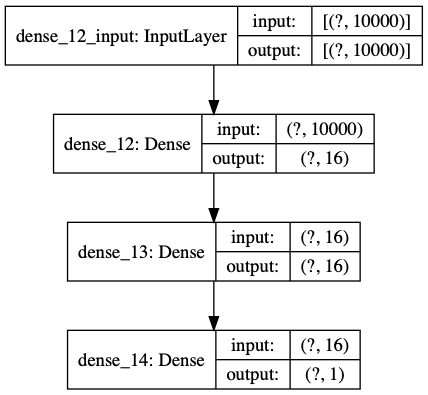

In [60]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True)

Next, we need to configure the model by specifying the optimizer to be used, the loss function and any error metrics we want to calculate. We'll use standard backpropagation for the optimizer, binary cross entropy for the loss function and we'll measure the model's accuracy. Cross entropy is a measure of how different two distributions are, and this is well suited to a binary classification exercise, where we want to discriminate between 0's and 1's,

In [61]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

### Training the model

Now we have everything in place, we can train the model. Here we specify:

- the set of features for training (`partial_x_train`)
- the set of labels for training (`partial_y_train`)
- the number of iterations to train the model for (`epochs`)
- the `batch_size`. 
- the validation features and labels

The batch size is quite an useful parameter to make your network more efficient. This is the number of samples to pass through the network before updating weights. This allows you to trade off the speed of the calculation against the convergence. Using smaller batches uses less memory but may take longer to converge, as the weights are being updated using only a fraction of the data. Larger batches will converge quickly, by may cause memory issues, and may more easily result in overfitting. 

In [62]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 170us/sample - loss: 0.5181 - acc: 0.7792 - val_loss: 0.3940 - val_acc: 0.8704
Epoch 2/20
15000/15000 [==============================] - 1s 63us/sample - loss: 0.3137 - acc: 0.9037 - val_loss: 0.3111 - val_acc: 0.8850
Epoch 3/20
15000/15000 [==============================] - 1s 61us/sample - loss: 0.2300 - acc: 0.9273 - val_loss: 0.2957 - val_acc: 0.8836
Epoch 4/20
15000/15000 [==============================] - 1s 59us/sample - loss: 0.1824 - acc: 0.9433 - val_loss: 0.2835 - val_acc: 0.8862
Epoch 5/20
15000/15000 [==============================] - 1s 78us/sample - loss: 0.1477 - acc: 0.9530 - val_loss: 0.2918 - val_acc: 0.8838
Epoch 6/20
15000/15000 [==============================] - 1s 80us/sample - loss: 0.1205 - acc: 0.9621 - val_loss: 0.2878 - val_acc: 0.8873
Epoch 7/20
15000/15000 [==============================] - 1s 61us/sample - loss: 0.1012 - acc: 0.9698 - val_loss: 0

The output from the training (`history`) contains the evolution of the loss function and performance metric, and we can use this to visualize the progression of the model:

In [63]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

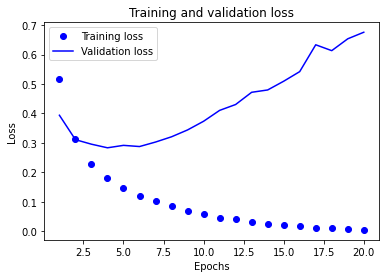

In [64]:
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')          

plt.plot(epochs, val_loss_values, 'b', label='Validation loss')     

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

And here's the change in the accuracy:

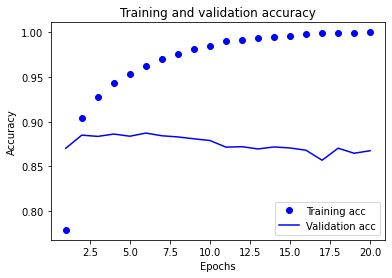

In [65]:
plt.clf()                                                           

acc = history_dict['acc']
val_acc = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The lines show the loss and accuracy for the training dataset, with a maximum accuracy close to 1. The blue points show the same for the validation dataset, and show clear signs of overfitting. There is a peak in accuracy (and a minimum in the loss function) at around 5 epochs. We'll refit our model with a smaller number of epochs to the full training set, and then go on to test it.


In [66]:
model = models.Sequential([
  layers.Dense(16, activation='relu', input_shape=(10000,)),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs = 5, batch_size = 512)

Train on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 2s 86us/sample - loss: 0.4461 - accuracy: 0.8141
Epoch 2/5
25000/25000 [==============================] - 1s 39us/sample - loss: 0.2561 - accuracy: 0.9093
Epoch 3/5
25000/25000 [==============================] - 1s 38us/sample - loss: 0.1983 - accuracy: 0.9300
Epoch 4/5
25000/25000 [==============================] - 1s 38us/sample - loss: 0.1670 - accuracy: 0.9409
Epoch 5/5
25000/25000 [==============================] - 1s 41us/sample - loss: 0.1426 - accuracy: 0.9492


We can test the model by using the `evaluate()` method and the original test (not validation!) dataset:

In [67]:
results = model.evaluate(x_test, y_test, verbose=0)

In [68]:
print('Final loss: %.4f'
      % results[0])
print('Final accuracy: %.4f'
      % results[1])

Final loss: 0.3198
Final accuracy: 0.8764


We get an accuracy of about 87%, which is not bad for a first attempt. The next steps would be to modify the network architecture to see if this could be improved on, e.g. by adding more layers or more nodes in the layers. We'll finish here by making a quick prediction using our trained network, but feel free to try and change your network. 

We'll take the first 10 reviews from the test data and use the `predict()` method to get a predicted probability of this being a good review:

In [69]:
model.predict(x_test[0:10])

array([[0.12788025],
       [0.99964476],
       [0.88272035],
       [0.8012439 ],
       [0.93102396],
       [0.7756307 ],
       [0.999588  ],
       [0.00387275],
       [0.97479093],
       [0.9933569 ]], dtype=float32)

This shows a fair range, with some reviews being predicted as very close to 0 or 1, but others where there is greater uncertainty. One thing to do would be to take the function that back transforms the reviews, and look at an example that has been predicted close to 0 or 1 to see what was actually written.

## Example 2: regression

For the second example, we'll demonstrate a regression example, as well as a $k$-fold cross-validation. We'll use data on house prices and neighborhood characteristics from Boston, in the file *boston6k.csv*. Start by reading this data in, and take a quick look at the values:

In [70]:
import numpy as np
import pandas as pd

boston = pd.read_csv("../datafiles/boston6k.csv")

Load data

In [71]:
boston.head()

,ID,TOWN,TOWNNO,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,...,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1,Boston Allston-Brighton,74,1,-71.139367,42.362447,17.8,17.8,8.98296,0.0,...,1,0.77,6.212,97.4,2.1222,24,666,20.2,377.73,17.60
1,2,Boston Allston-Brighton,74,2,-71.158552,42.353116,21.7,21.7,3.84970,0.0,...,1,0.77,6.395,91.0,2.5052,24,666,20.2,391.34,13.27
2,3,Boston Allston-Brighton,74,3,-71.168487,42.350608,22.7,22.7,5.20177,0.0,...,1,0.77,6.127,83.4,2.7227,24,666,20.2,395.43,11.48
3,4,Boston Allston-Brighton,74,4,-71.156163,42.343818,22.6,22.6,4.26131,0.0,...,0,0.77,6.112,81.3,2.5091,24,666,20.2,390.74,12.67
4,5,Boston Allston-Brighton,74,5,-71.155807,42.337318,25.0,25.0,4.54192,0.0,...,0,0.77,6.398,88.0,2.5182,24,666,20.2,374.56,7.79


Summary information

In [72]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       506 non-null    int64  
 1   TOWN     506 non-null    object 
 2   TOWNNO   506 non-null    int64  
 3   TRACT    506 non-null    int64  
 4   LON      506 non-null    float64
 5   LAT      506 non-null    float64
 6   MEDV     506 non-null    float64
 7   CMEDV    506 non-null    float64
 8   CRIM     506 non-null    float64
 9   ZN       506 non-null    float64
 10  INDUS    506 non-null    float64
 11  CHAS     506 non-null    int64  
 12  NOX      506 non-null    float64
 13  RM       506 non-null    float64
 14  AGE      506 non-null    float64
 15  DIS      506 non-null    float64
 16  RAD      506 non-null    int64  
 17  TAX      506 non-null    int64  
 18  PTRATIO  506 non-null    float64
 19  B        506 non-null    float64
 20  LSTAT    506 non-null    float64
dtypes: float64(14), 

Value 

In [73]:
boston.describe()

,ID,TOWNNO,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,253.500000,47.531621,2700.355731,-71.094343,42.360270,22.532806,22.528854,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,146.213884,27.571401,1380.036830,0.125508,0.103696,9.197104,9.182176,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,1.000000,0.000000,1.000000,-71.485152,42.045973,5.000000,5.000000,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,127.250000,26.250000,1303.250000,-71.156074,42.299922,17.025000,17.025000,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,253.500000,42.000000,3393.500000,-71.088686,42.362347,21.200000,21.200000,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,379.750000,78.000000,3739.750000,-71.031016,42.423070,25.000000,25.000000,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,506.000000,91.000000,5082.000000,-70.680481,42.637086,50.000000,50.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


### Data processing

Next, we'll split out the features (we'll use a subset of the available information) and the labels. The 'labels` we are going to model are the corrected median house values in $000s (from the 1970's - that's why it looks so cheap). 

In [74]:
boston2 = boston.iloc[:,7:21]
boston2.columns

Index(['CMEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
       'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

Let's plot the features out as histograms.

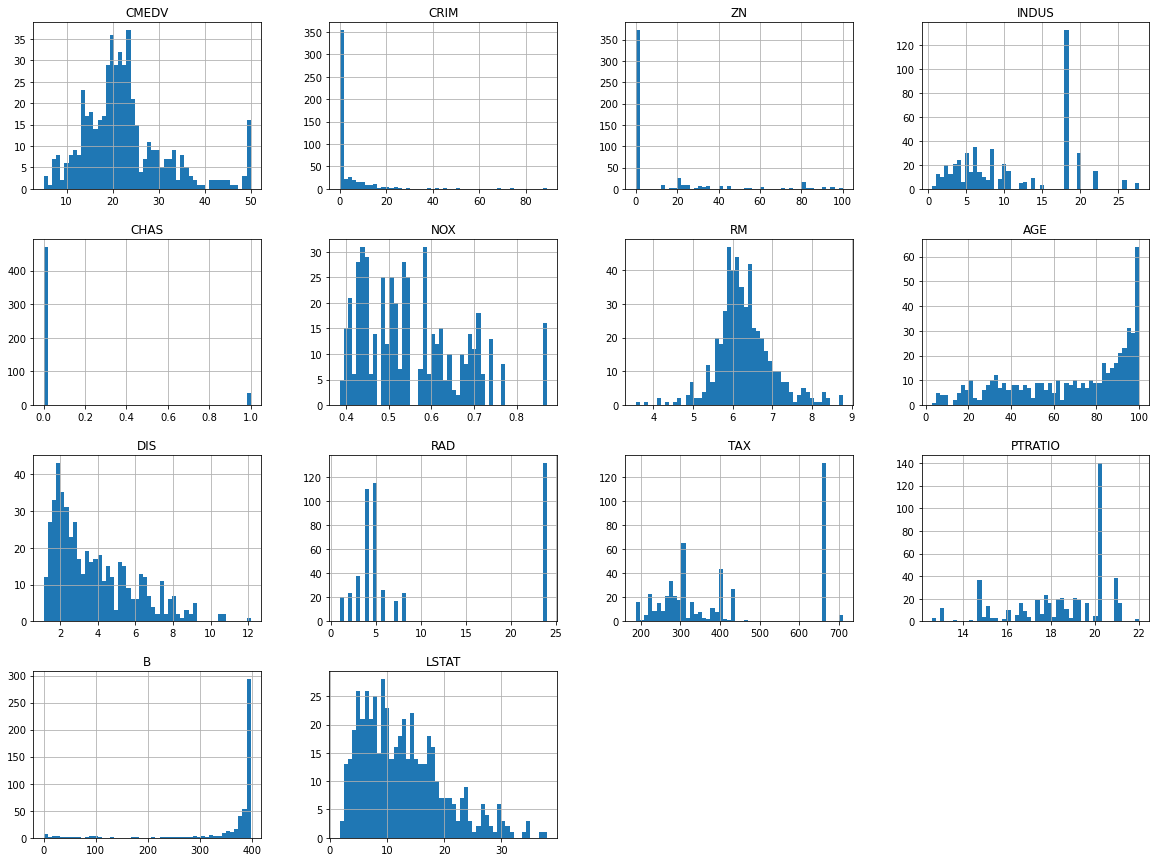

In [75]:
## %matplotlib inline
import matplotlib.pyplot as plt
boston2.hist(bins=50, figsize=(20,15))
plt.show()

Next, we'll make up a training and testing dataset, by adding 80% of the samples randomly to training and leaving the rest for testing. We can use scikit-learn's tools for this:

In [76]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(boston2, test_size=0.2, random_state=42)

Then split these into features and labels:

In [77]:
X_train = train.drop('CMEDV', axis=1).values
y_train = train['CMEDV'].values
print(X_train.shape)
print(y_train.shape)

(404, 13)
(404,)


In [78]:
X_test = test.drop('CMEDV', axis=1).values
y_test = test['CMEDV'].values
print(X_test.shape)
print(y_test.shape)

(102, 13)
(102,)


The features are on quite different scales, so we'll standardize them to $z$-scores. To do this, we'll use scikit-learn's `StandardScaler`. First import and fit this to the training data

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

Then use it to transform the two sets of features:

In [80]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Setting up the network

We'll build a model that again has two hidden layers and a single output node. We'll use use the ReLU activation function and slightly more nodes in each hidden layer than in the previous example. One difference here is that we'll create a function (`build_model()`) that contains all the code to set up a Keras neural network. This just contains the two sets of instructions to build a sequential model and compile it together with loss and performance metrics (we're using the mean square error for loss and the mean absolute error for performance:

In [84]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    model = models.Sequential([                        

      layers.Dense(64, activation='relu', input_shape=(13,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Now we can create a new, untrained version of our network by calling this function:

In [85]:
model = build_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


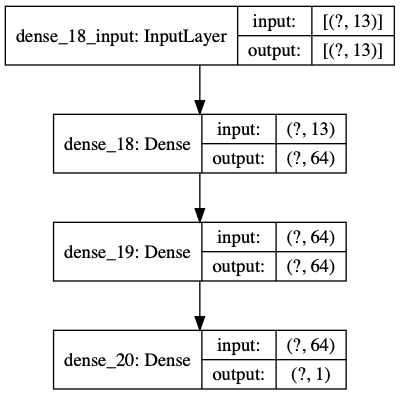

In [87]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True)

### Cross-validation 

We'll now set up a cross-validation strategy by hand using scikit-learns `KFold` function. In the following code, we:

- Use `KFold` to define indices for 4 folds of the training data.
- Define the number of epochs to run for (250)
- Create a blank object to store training information
- Run a loop 4 times. In each iteration:
    - We get the index for the training and validation samples
    - Uses these to extract observations for the validation set (`X_val`, `y_val`), and for the training feature and labels (`X_partial_train`, `y_partial_train`)
    - Build a new, untrained network using the function we created earlier
    - Train the model for the set number of epochs, using a batch size of 16
    - Store the validated MAE in `all_mae_histories`
    
Copy this over, check the code and run it. It will take a couple of minutes to iterate across all the training

In [89]:
k = 4
from sklearn.model_selection import KFold
kf = KFold(n_splits = k)

num_epochs = 250
all_mae_histories = []
i = 1
for train_partial_index, val_index in kf.split(X_train):
    print('processing fold #%d' % i)
    X_val = X_train[val_index]  
    y_val = y_train[val_index]
    
    X_partial_train = X_train[train_partial_index]
    y_partial_train = y_train[train_partial_index]
    
    model = build_model()                                                  

    history = model.fit(X_partial_train, y_partial_train,
                        validation_data=(X_val, y_val),
                        epochs=num_epochs, batch_size=16, verbose=0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    i += 1

processing fold #1
processing fold #2
processing fold #3
processing fold #4


We can now average across the 4 folds, and plot the evolution of the MAE

In [73]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

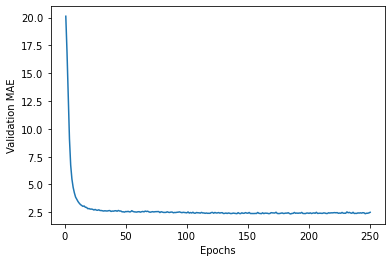

In [74]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

The large drop in MAE over the first few epochs makes it quite difficult to see if and when the model reached an optimum. We'll remake this plot without the first 10 values:

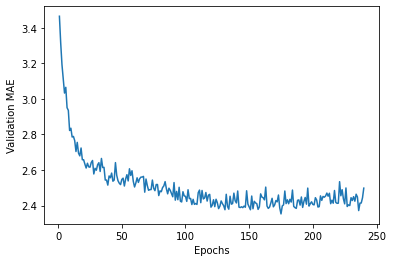

In [77]:
average_mae_history2 = average_mae_history[10:]
plt.plot(range(1, len(average_mae_history2) + 1), average_mae_history2)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [85]:
model = build_model()
history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=125, batch_size=16, verbose=1)

In [86]:
test_mse_score, test_mae_score = model.evaluate(X_test, y_test, verbose=0)

In [88]:
test_mae_score

2.2378213

As before, there are several modifications you could try to this basic network to attempt to improve on this. 

## Exercise

For the exercise we will once again use the data from the *Sonar.csv* file to model types of object (rocks 'R' or mines 'M') using the values of a set of frequency bands. The goal this time is to construct a neural network using Keras. You will need to do the following:

- Import the data and divide it into a training and test set
- Design a network
- Train the network for a number of epochs with a validation set (use the `binary_crossentropy` loss function)
- Identify the optimum number of epochs
- Run the model with the full training set
- Evaluate the model on the test set and report the *accuracy* of your final model

All the code to do this is in the two examples of this lab. You submitted answers should contain:

- A description of your network, including the summary table (from the `summary(model)` function)
- A figure showing the evolution of the loss function and accuracy
- The accuracy of your final model


## Appendix

### Boston housing dataset: *boston6k.csv*
| Column header | Variable |
| --- | --- |
| ID | Sequential ID |
| TOWN | Town names |
| TOWNNO | Town ID |
| TRACT | Tract ID numbers |
| LON | Longitude in decimal degrees |
| LAT | Latitude in decimal degrees |
| MEDV | Median values of owner-occupied |
|  | housing (USD 1000) |
| CMEDV | Corrected median values of owner-occupied |
|  | housing (USD 1000) |
| CRIM | Per capita crime |
| ZN | Proportion of residential land zoned |
| | for lots over 25000 sq. ft |
| INDUS | Proportions of non-retail business acres per town |
| CHAS | 1 if tract borders Charles River; 0 otherwise |
| NOX | Nitric oxides concentration (parts per 10 million) |
| RM | Average numbers of rooms per dwelling |
| AGE | Proportions of owner-occupied units built prior to 1940 |
| DIS | Weighted distances to five Boston employment centers |
| RAD | Index of accessibility to radial highways per town |
| TAX | Property-tax rate per USD 10,000 per town |
| PTRATIO | Pupil-teacher ratios per town |
| B | Proportion African-American |
| LSTAT | Percent lower status population |